# CHECK EFFECT OF VARIOUS MASKING AND INPAINTING METHODS

In [9]:
import wandb
import os
import numpy as np
import matplotlib.pyplot as plt
import json

wandb.login()
api = wandb.Api()

In [10]:
os.chdir("/home/thesis/marx/wilson_gen/WILSON")

In [11]:
# # CLEAN UP ALL RUNS NOT LISTED IN WANDB HOMEPAGE

# run_ids = []
# for run in api.runs("WILSON"):
#     run_ids.append(run.id)

# for run in os.listdir("wandb"):
#     if "run-" in run:
#         if run.split("-")[-1] not in run_ids:
#             print(f"Deleting {run}")
#             os.system(f"rm -rf wandb/{run}")

In [12]:
def get_miou(run):
    run_dir = [run_dir for run_dir in os.listdir("wandb") if run in run_dir][0]
    with open(f"wandb/{run_dir}/files/wandb-summary.json", "r") as f:
        summary = json.load(f)
    mean_iou = np.array(summary["Val/MeanIoU/1"])
    old_miou = np.array(summary["Val/MeanIoU_Old/1"])
    new_miou = np.array(summary["Val/MeanIoU_New/1"])
    return np.array([old_miou, new_miou, mean_iou])

In [13]:
runs = list(r for r in api.runs("gooogleon-uni-hd/WILSON") if "mask_inp_sweep" in r.tags)
print(f"Found {len(runs)} runs")

Found 16 runs


In [14]:
def get_run_by_name(run_name, ids=None):
    fitting_runs = []
    for run in runs:
        if run_name in run.name:
            fitting_runs.append(run)
    if len(fitting_runs) == 1:
        return fitting_runs[0]
    elif ids is not None:
        for run in fitting_runs:
            if run.id in ids:
                return run
    if len(fitting_runs) == 0:
        if "No1h_" in run_name:
            return get_run_by_name(run_name.replace("No1h_", ""), ids)
    print(f"Found {len(fitting_runs)} fitting runs for {run_name}")
    for run in fitting_runs:
        print(run.id)
    print("Check run id and try again")
    return None

In [15]:
def plot_grid(mode):
    # ids = ["pvo7tt0o", "l5ds88p1", "klqkaxhu", "0ymnjr3i", "yapxe6w0", "qkaoxej1"]
    # ids = ["pvo7tt0o", "l5ds88p1", "klqkaxhu", "0ymnjr3i", "yapxe6w0", "qkaoxej1", "blmiytza", "huc5urkq", "krdnra8x", "ozeznoi1", "byd17t9e"]
    ids = []
    fig, axes = plt.subplots(4, 2, figsize=(12, 16), sharex=True, sharey=True)
    for i, inpainting in enumerate(["No1h", "Old1h", "New1h", "Both1h"]):
        if mode == "scores":
            base_baseline_mious = np.zeros(3)
        elif mode == "compare inp_base":
            base_baseline = get_run_by_name(f"voc-10-10-ov_Incr_Gen_Base_{inpainting}_Masked_none_RR", ids=ids)
            base_baseline_mious = get_miou(base_baseline.id)
        elif mode == "compare base":
            base_baseline = get_run_by_name(f"voc-10-10-ov_Incr_Gen_Base_No1h_Masked_none_RR", ids=ids)
            base_baseline_mious = get_miou(base_baseline.id)
        else:
            raise ValueError("mode must be one of 'scores', 'compare inp_base', 'compare base'")

        for j, replay_set in enumerate(["Base", "Lora"]):
            no_mask = get_run_by_name(f"voc-10-10-ov_Incr_Gen_{replay_set}_{inpainting}_Masked_none_RR", ids=ids)
            no_mask_mious = get_miou(no_mask.id)

            axes[i, j].plot(no_mask_mious - base_baseline_mious, label="no_mask")
            axes[i, j].set_xticks([0, 1, 2], ["Old MIoU", "New MIoU", "Tot MIoU"])
            axes[0, j].set_title(replay_set)
            if mode != "scores":
                axes[i, j].plot([0, 1, 2], [0, 0, 0], "k--")

            for masking in ["all_loc"]:
            # for masking in ["l_cam_new", "l_loc", "lde", "l_seg", "l_cls", "all_loc"]:
                masked = get_run_by_name(f"voc-10-10-ov_Incr_Gen_{replay_set}_{inpainting}_Masked_{masking}_RR", ids=ids)
                masked_mious = get_miou(masked.id)
                axes[i, j].plot(masked_mious - base_baseline_mious, label=masking)
                axes[i, j].set_xticks([0, 1, 2], ["Old MIoU", "New MIoU", "Tot MIoU"])
        axes[i, 0].set_ylabel(inpainting)
        axes[i, 1].legend(bbox_to_anchor=(1.01, 1.014))
    plt.tight_layout()
    plt.show()

# ACTUAL SCORES FOR EACH REPLAY SET, INPAINTING AND MASKING

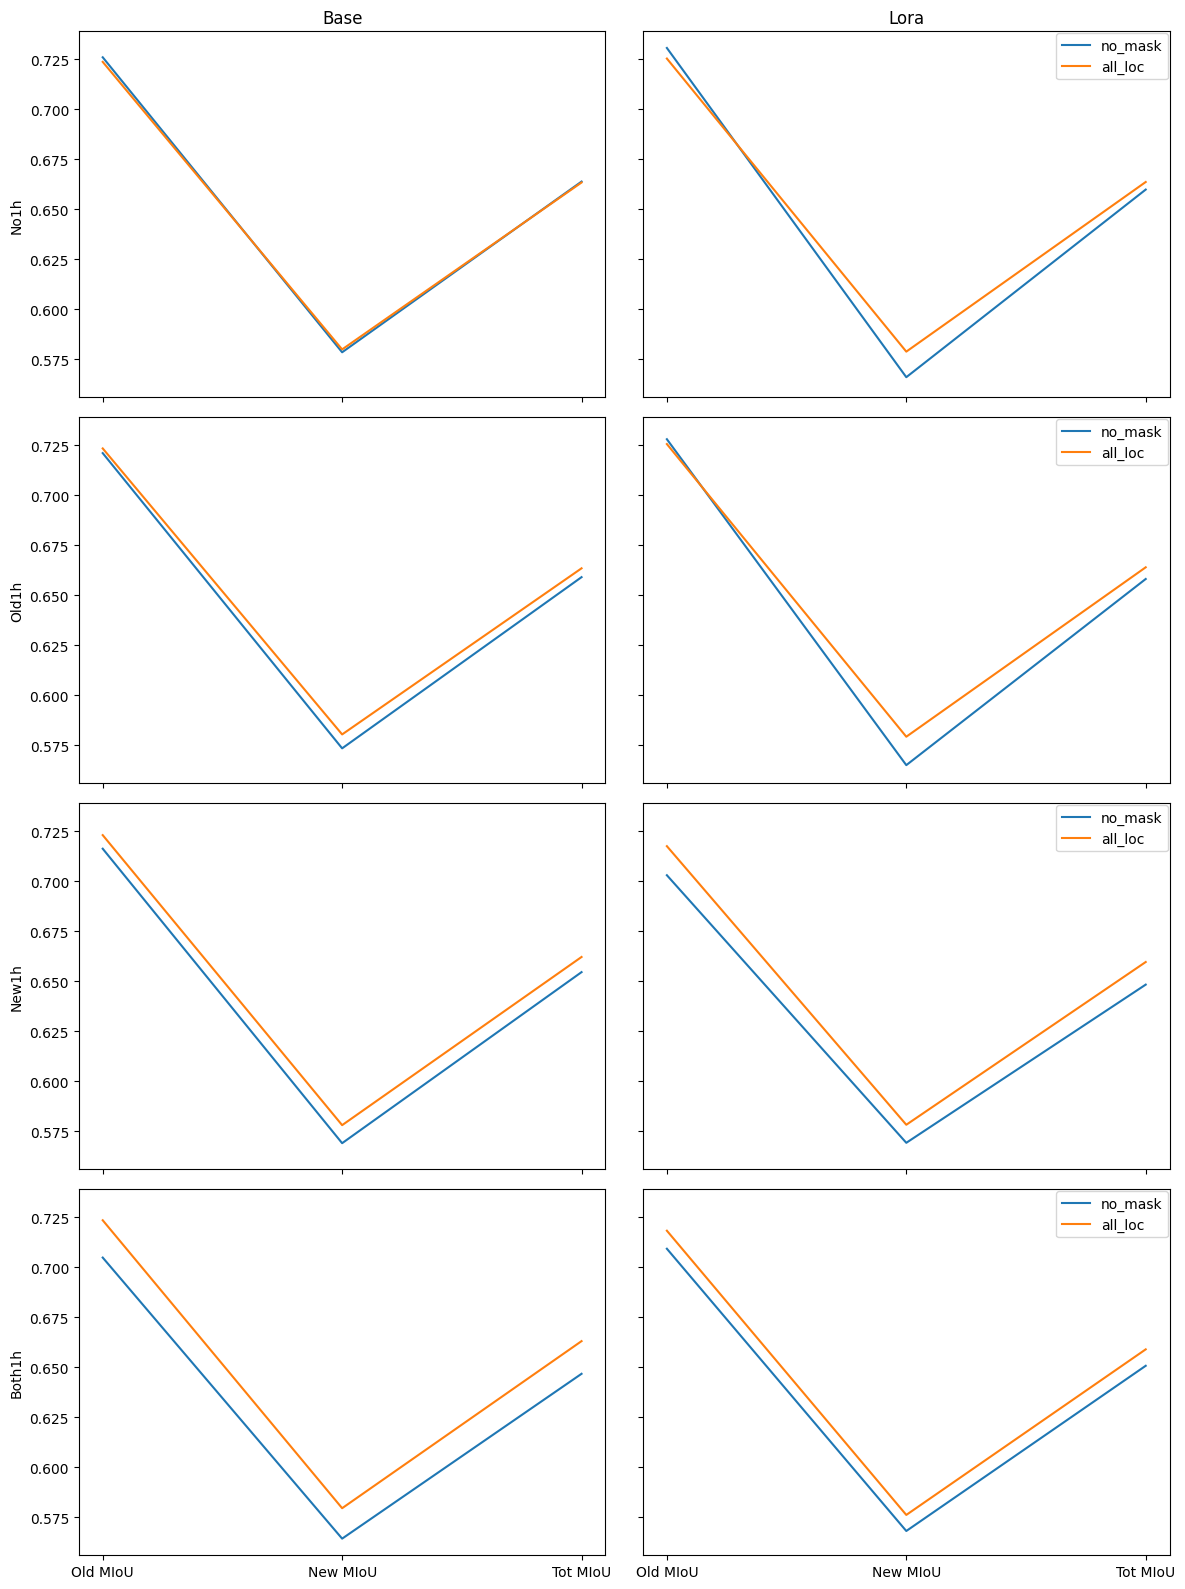

In [16]:
plot_grid("scores")

# SCORES COMPARED AGAINST THE BASE SCORE OF EACH INPAINTING METHOD

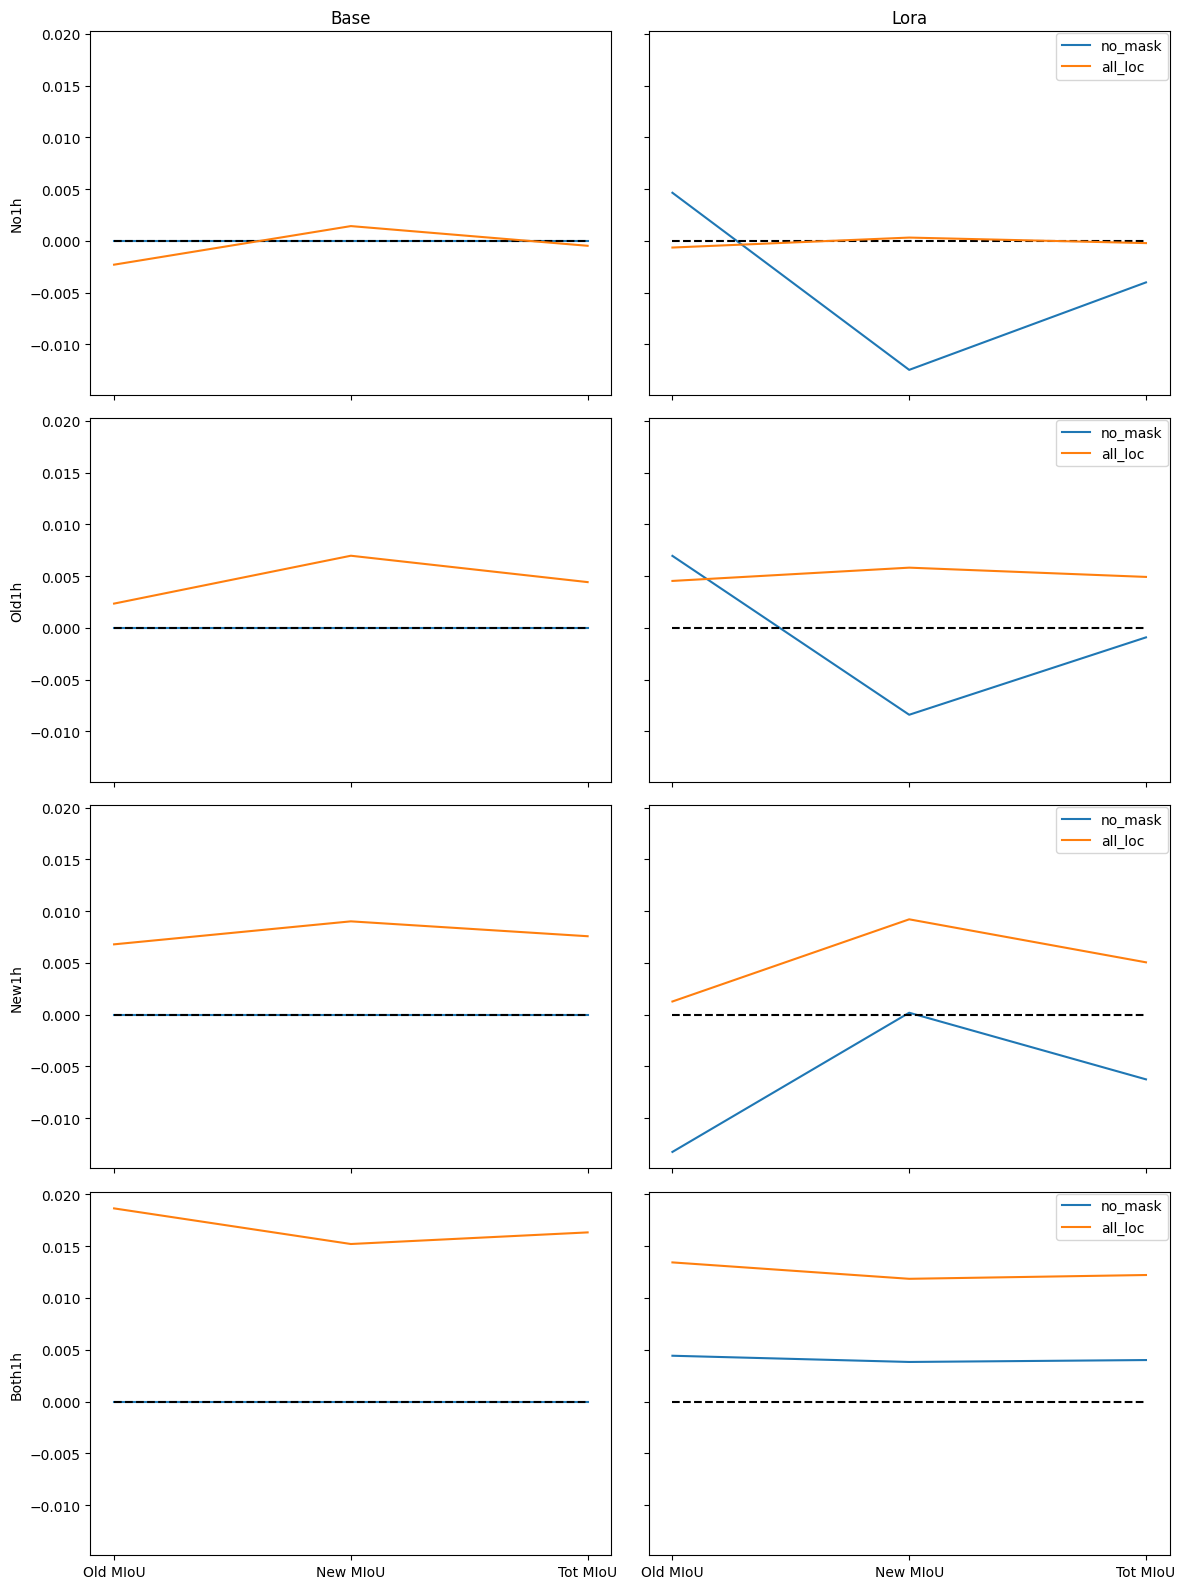

In [17]:
plot_grid("compare inp_base")

# SCORES COMPARED AGAINST BASELINE WITH NO INPAINTING AND NO MASKING

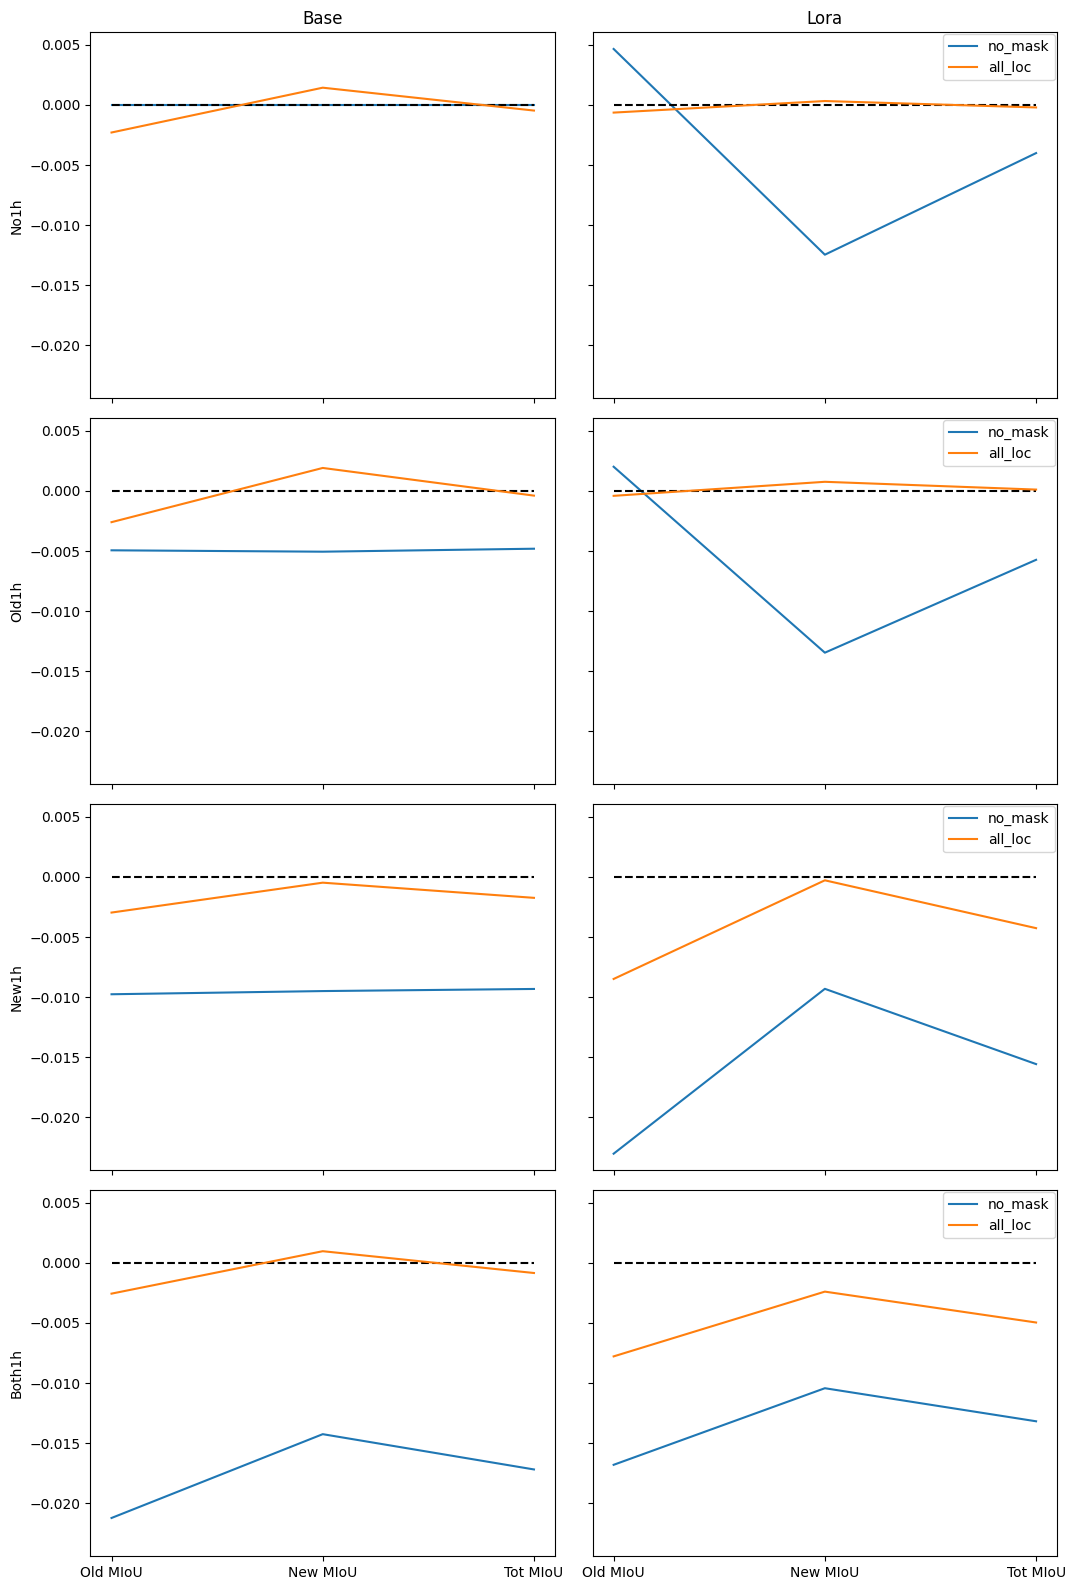

In [18]:
plot_grid("compare base")